# **Projeto 1 - Previsão de séries temporais com métodos estatísticos**

O dataset [**“CO₂ Emissions”**](https://www.kaggle.com/datasets/ulrikthygepedersen/co2-emissions-by-country), disponível no Kaggle, reúne séries anuais de emissões de gases de efeito estufa e CO₂ para países e setores globais. Ele inclui variáveis como emissões totais, PIB e população, permitindo observar a evolução histórica das emissões e suas relações econômicas. Para esta análise, foi utilizada a série global de emissões totais (`total_ghg`), representando o comportamento agregado das emissões ao longo do tempo.

## **Importando bibliotecas**

In [1]:
# ===== Bibliotecas padrão =====
import warnings

# ===== Manipulação de dados =====
import numpy as np
import pandas as pd

# ===== Visualização =====
import matplotlib.pyplot as plt

# ===== Estatística e distribuição =====
from scipy.stats import gaussian_kde, norm

# ===== Modelos de séries temporais =====
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

# ===== Avaliação e métricas =====
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
warnings.filterwarnings("ignore")

## **Carregando os dados**

In [3]:
csv_path = 'co2_emissions.csv'
df = pd.read_csv(csv_path)
df

,Description,Name,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,Country,Afghanistan,1850,AFG,3752993.0,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.436,0.629,NaN,NaN
1,Country,Afghanistan,1851,AFG,3767956.0,NaN,0.0,0.0,NaN,NaN,...,NaN,0.156,0.0,0.0,0.0,0.0,7.500,0.633,NaN,NaN
2,Country,Afghanistan,1852,AFG,3783940.0,NaN,0.0,0.0,NaN,NaN,...,NaN,0.155,0.0,0.0,0.0,0.0,7.560,0.637,NaN,NaN
3,Country,Afghanistan,1853,AFG,3800954.0,NaN,0.0,0.0,NaN,NaN,...,NaN,0.155,0.0,0.0,0.0,0.0,7.620,0.641,NaN,NaN
4,Country,Afghanistan,1854,AFG,3818038.0,NaN,0.0,0.0,NaN,NaN,...,NaN,0.155,0.0,0.0,0.0,0.0,7.678,0.644,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43741,International_Sector,International transport,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
43742,International_Sector,International transport,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
43743,International_Sector,International transport,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
43744,International_Sector,International transport,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [4]:
df_world = df[df["Name"] == "World"]
df_world

,Description,Name,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
37807,Region,World,1850,NaN,1.287034e+09,1.546680e+12,NaN,NaN,196.848,11.800,...,NaN,NaN,NaN,NaN,NaN,NaN,4219.061,681.081,NaN,NaN
37808,Region,World,1851,NaN,NaN,NaN,NaN,NaN,198.779,1.931,...,NaN,100.0,0.000,0.001,0.002,0.000,4409.311,684.198,NaN,NaN
37809,Region,World,1852,NaN,NaN,NaN,NaN,NaN,207.595,8.817,...,NaN,100.0,0.001,0.003,0.004,0.000,4465.078,696.189,NaN,NaN
37810,Region,World,1853,NaN,NaN,NaN,NaN,NaN,217.237,9.642,...,NaN,100.0,0.001,0.004,0.006,0.000,4532.813,709.859,NaN,NaN
37811,Region,World,1854,NaN,NaN,NaN,NaN,NaN,255.039,37.802,...,NaN,100.0,0.002,0.006,0.008,0.000,4594.583,756.674,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37976,Region,World,2019,NaN,7.811294e+09,1.221490e+14,1623.120,0.208,37104.273,373.850,...,100.0,100.0,0.401,1.090,1.571,0.080,52796.523,43147.367,0.004,0.0
37977,Region,World,2020,NaN,7.887001e+09,1.185900e+14,1638.271,0.208,35126.527,-1977.750,...,100.0,100.0,0.406,1.107,1.595,0.081,50792.543,41394.840,0.000,0.0
37978,Region,World,2021,NaN,7.954448e+09,1.260050e+14,1696.308,0.213,36991.734,1865.208,...,100.0,100.0,0.411,1.125,1.619,0.083,52938.793,43391.352,0.004,0.0
37979,Region,World,2022,NaN,8.021407e+09,1.301130e+14,1601.124,0.200,37293.836,302.100,...,100.0,100.0,0.417,1.143,1.644,0.084,53327.215,43746.762,0.004,0.0


In [5]:
df_world.isna().mean().sort_values().head(50)

Description                                  0.000000
cumulative_co2                               0.000000
cumulative_co2_including_luc                 0.000000
share_global_coal_co2                        0.000000
cumulative_luc_co2                           0.000000
cumulative_other_co2                         0.000000
share_global_cumulative_luc_co2              0.000000
share_global_cumulative_coal_co2             0.000000
share_global_cumulative_co2_including_luc    0.000000
land_use_change_co2                          0.000000
methane                                      0.000000
nitrous_oxide                                0.000000
other_industry_co2                           0.000000
share_global_cumulative_co2                  0.000000
share_global_co2                             0.000000
share_global_co2_including_luc               0.000000
share_global_luc_co2                         0.000000
coal_co2                                     0.000000
cumulative_coal_co2         

Utilizou-se apenas a variável endógena total_ghg porque ela apresenta cobertura completa (0% nulos) e sintetiza o comportamento agregado das emissões

In [6]:
world = df_world.set_index("year")[["total_ghg"]].astype(float)
world

,total_ghg
year,
1850,4219.061
1851,4409.311
1852,4465.078
1853,4532.813
1854,4594.583
...,...
2019,52796.523
2020,50792.543
2021,52938.793


In [7]:
world.isna().sum()

total_ghg    0
dtype: int64

In [8]:
serie = world.copy()
serie

,total_ghg
year,
1850,4219.061
1851,4409.311
1852,4465.078
1853,4532.813
1854,4594.583
...,...
2019,52796.523
2020,50792.543
2021,52938.793


In [9]:
serie.describe()

,total_ghg
count,174.000000
mean,20242.299391
std,15469.418765
min,4219.061000
25%,7713.235250
50%,12965.414500
75%,32715.112500
max,53816.852000


In [10]:
serie.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174 entries, 1850 to 2023
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   total_ghg  174 non-null    float64
dtypes: float64(1)
memory usage: 2.7 KB


## **Série temporal**

In [11]:
def plot_time_series(data, ylabel, title, color="#4C72B0"):
    """
    Cria um gráfico de série temporal.
    """
    plt.figure(figsize=(12, 5))
    plt.style.use("seaborn-v0_8-whitegrid")

    plt.plot(data.index, data.values, color=color, linewidth=1.3, label=data.name)

    # Eixos e título
    plt.xlabel("Datetime", fontsize=11, labelpad=8)
    plt.ylabel(ylabel, fontsize=11, labelpad=8)
    plt.title(title, fontsize=13, pad=10, weight="semibold")

    # Grade
    plt.grid(True, linestyle="--", alpha=0.6, which="both", axis="both")

    # Remover bordas superiores e direita
    for spine in ["top", "right"]:
        plt.gca().spines[spine].set_visible(False)

    # Legenda simples
    plt.legend(frameon=False)

    plt.tight_layout()
    plt.show()

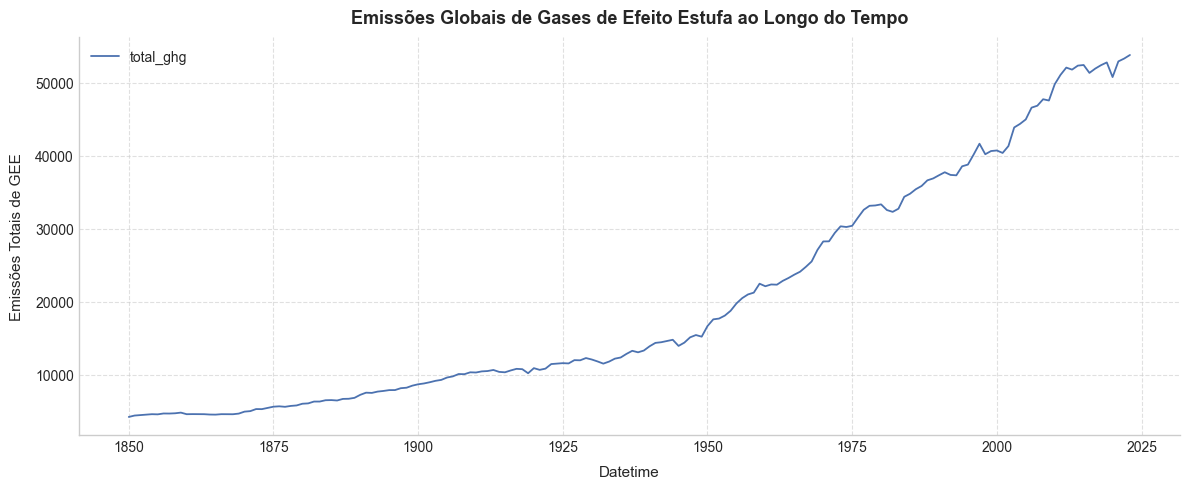

In [12]:
plot_time_series(
    serie["total_ghg"],
    ylabel="Emissões Totais de GEE",
    title="Emissões Globais de Gases de Efeito Estufa ao Longo do Tempo",
)   

## **Distribuição das variáveis principais**

In [13]:
def plot_distribution(data, xlabel, title, color="#4C72B0", bins=50):
    """
    Cria dois subplots:
    (1) Histograma limpo e técnico
    (2) Curva de densidade (KDE)
    """
    data = np.asarray(data)
    data = data[~np.isnan(data)]

    plt.figure(figsize=(9, 8))
    plt.style.use("seaborn-v0_8-whitegrid")

    # Histograma 
    plt.subplot(211)
    plt.hist(
        data,
        bins=bins,
        color=color,
        edgecolor="white",
        alpha=0.9
    )
    plt.ylabel("Frequência", fontsize=11, labelpad=8)
    plt.title(title, fontsize=13, pad=10, weight="semibold")
    plt.grid(True, linestyle="--", alpha=0.6, which="both", axis="both")
    for spine in ["top", "right"]:
        plt.gca().spines[spine].set_visible(False)

    # Curva de densidade (KDE)
    plt.subplot(212)
    kde = gaussian_kde(data)
    x = np.linspace(min(data), max(data), 500)
    plt.plot(x, kde(x), color=color, linewidth=2)
    plt.fill_between(x, kde(x), color=color, alpha=0.2)
    plt.xlabel(xlabel, fontsize=11, labelpad=8)
    plt.ylabel("Densidade", fontsize=11, labelpad=8)
    plt.grid(True, linestyle="--", alpha=0.6, which="both", axis="both")
    for spine in ["top", "right"]:
        plt.gca().spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()

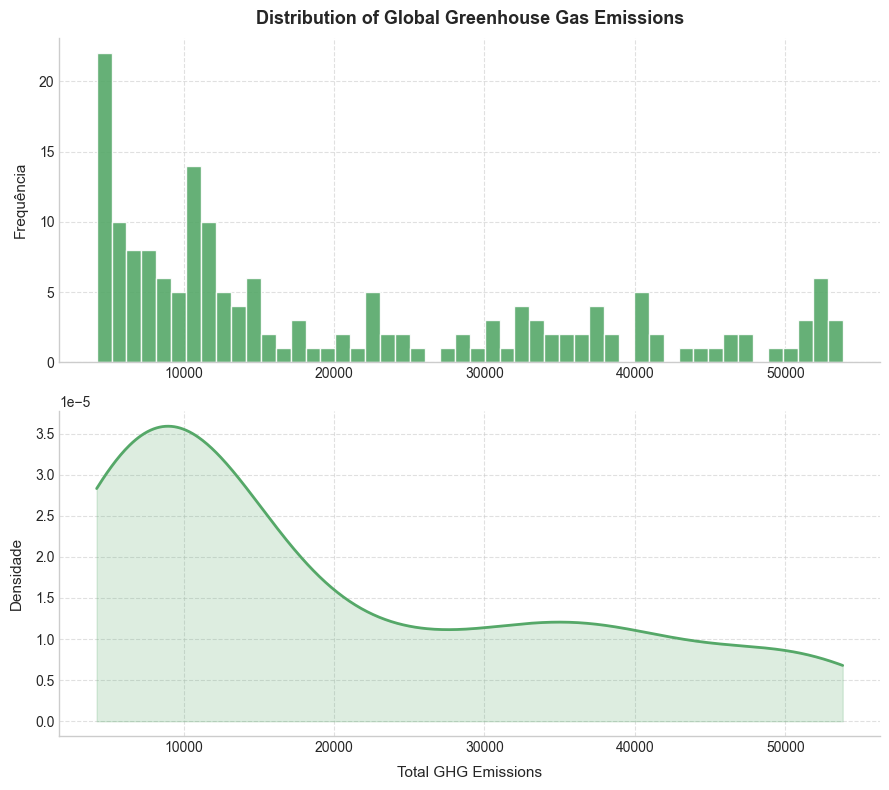

In [14]:
plot_distribution(
    serie["total_ghg"],
    xlabel="Total GHG Emissions",
    title="Distribution of Global Greenhouse Gas Emissions",
    color="#55A868"
)

## **Decomposição temporal (STL)**

In [15]:
# Primeiro, transformar o índice em datas
serie.index = pd.to_datetime(serie.index, format="%Y")

In [16]:
coluna = "total_ghg"

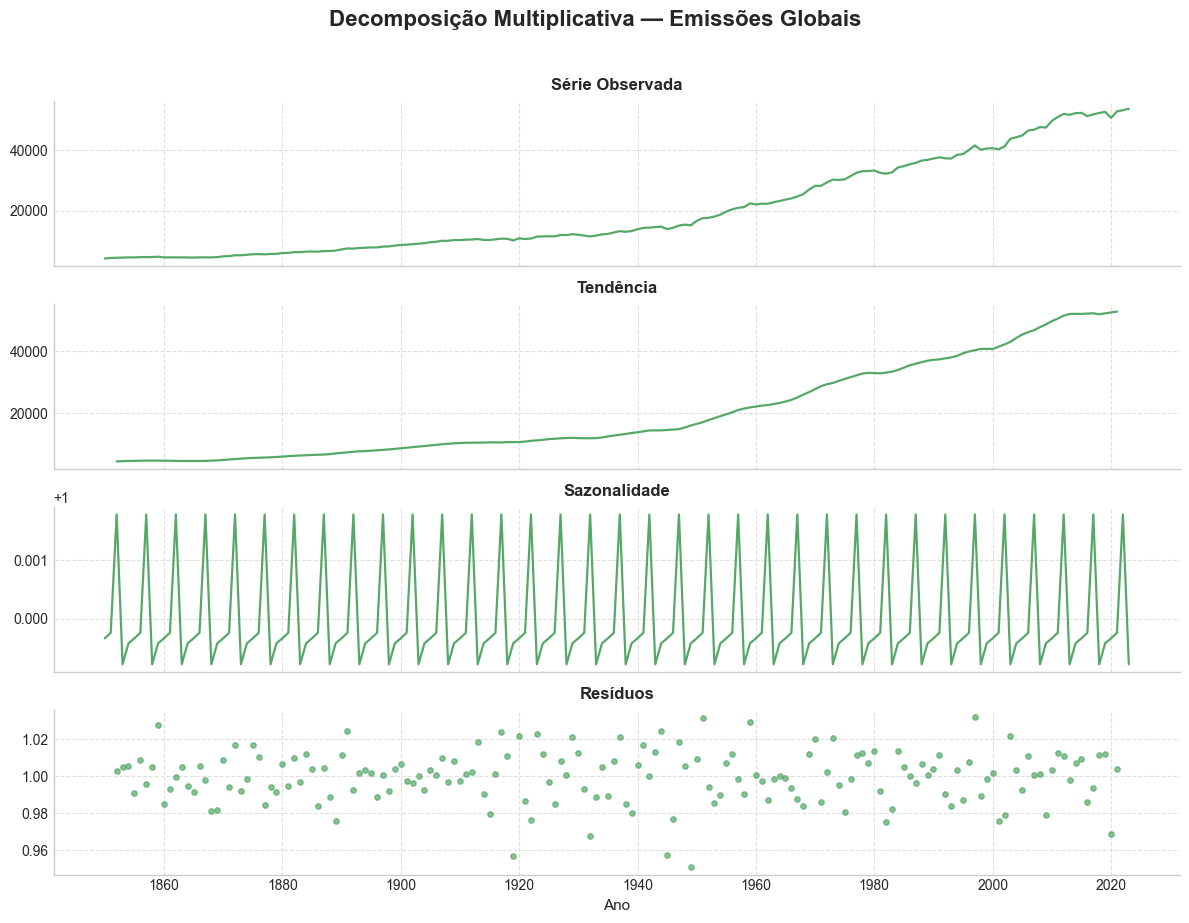

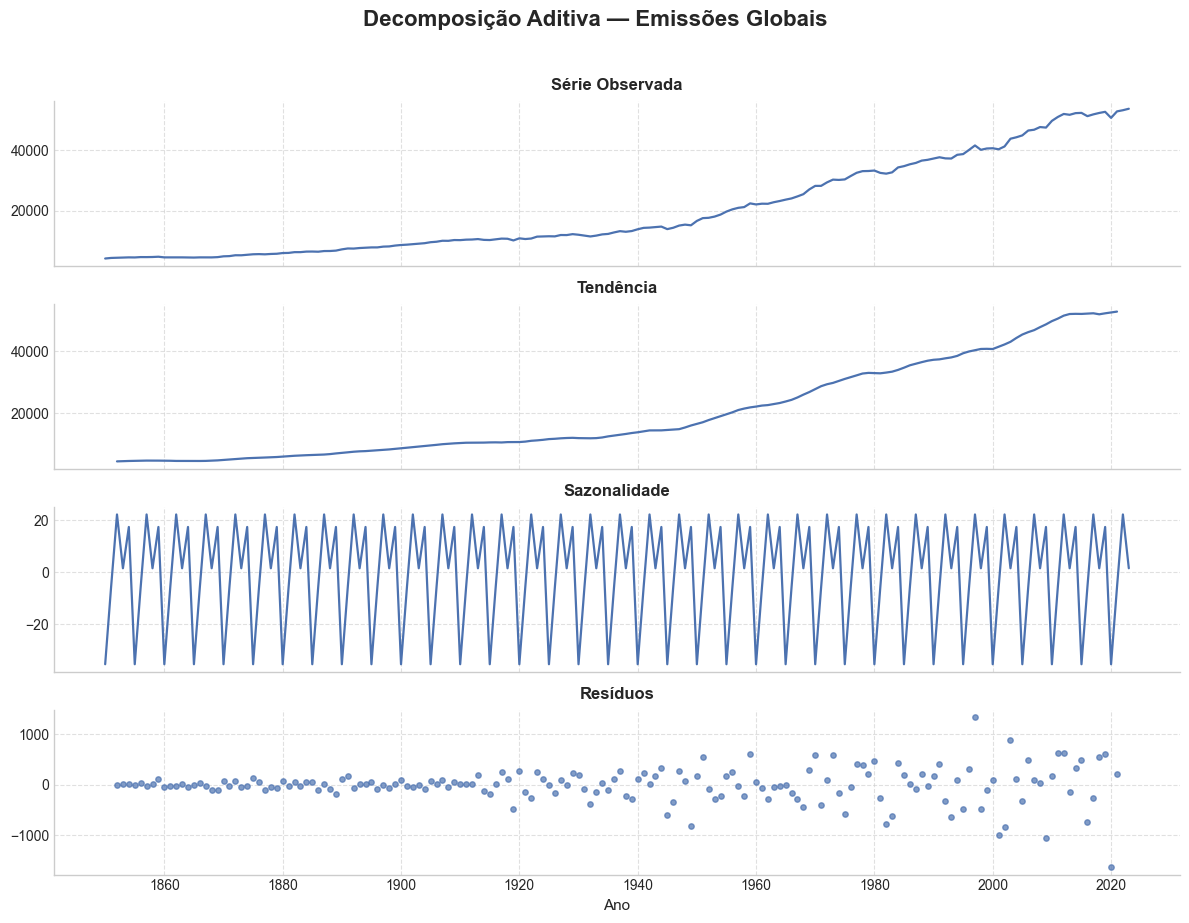

In [17]:
def plot_decomposition(data, model='multiplicative', period=10, color="#4C72B0", title=None):
    """
    Decompõe e plota a série temporal.
    - Linhas para observado, tendência e sazonalidade
    - Pontos para resíduos
    """
    plt.style.use("seaborn-v0_8-whitegrid")

    # Decomposição
    decomp = sm.tsa.seasonal_decompose(data, model=model, period=period)

    # Layout
    fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
    componentes = [
        ("Série Observada", decomp.observed, "line"),
        ("Tendência", decomp.trend, "line"),
        ("Sazonalidade", decomp.seasonal, "line"),
        ("Resíduos", decomp.resid, "scatter")
    ]

    # Loop dos componentes
    for ax, (titulo, serie, tipo) in zip(axes, componentes):
        if tipo == "line":
            ax.plot(serie, color=color, linewidth=1.6)
        else:
            ax.scatter(serie.index, serie, color=color, s=15, alpha=0.7)
        ax.set_title(titulo, fontsize=12, weight="semibold", pad=8)
        ax.grid(True, linestyle="--", alpha=0.6)
        for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)

    # Título geral da figura
    if title:
        fig.suptitle(title, fontsize=16, weight="semibold", y=1.02)

    plt.xlabel("Ano", fontsize=11)
    plt.tight_layout()
    plt.show()

    return decomp


# === Exemplo de uso ===
decomposicao_multiplicativa = plot_decomposition(
    serie,
    model="multiplicative",
    period=5,
    color="#55A868",
    title="Decomposição Multiplicativa — Emissões Globais"
)

decomposicao_aditiva = plot_decomposition(
    serie,
    model="additive",
    period=5,
    color="#4C72B0",
    title="Decomposição Aditiva — Emissões Globais"
)

## **Autocorrelação (ACF) e Autocorrelação Parcial (PACF)**

### **ACF – Autocorrelação**
Mede o quanto **cada valor da série está correlacionado com seus próprios valores** em diferentes atrasos (*lags*).  
É útil para identificar **padrões de repetição** ou **dependência temporal** ao longo do tempo.

### **PACF – Autocorrelação Parcial**
Mede a **correlação direta entre o valor atual e um lag específico**, **removendo o efeito dos lags intermediários**.  
Ajuda a identificar **relações autoregressivas diretas**, isolando a influência de defasagens anteriores.

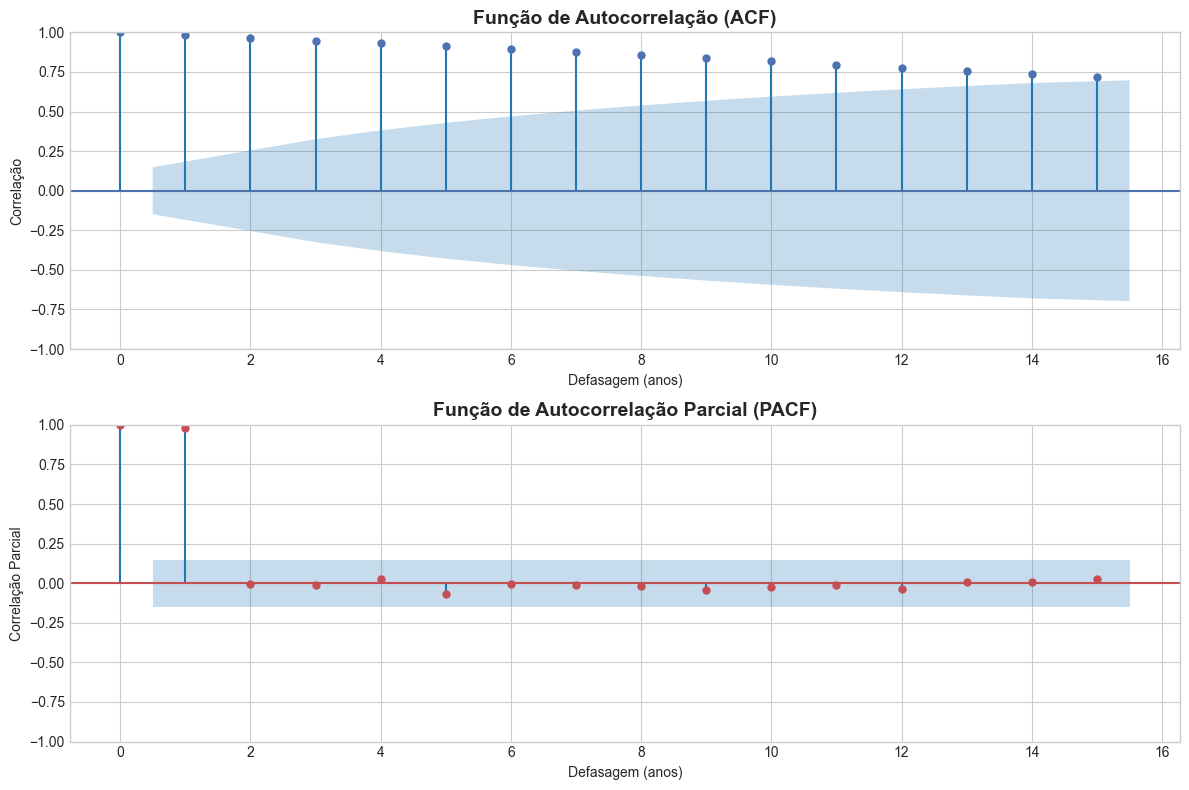

In [18]:
# Quantidade de defasagens (lags)
lags = 15 # 15 anos de dados anuais

# Plot ACF e PACF
plt.rcParams.update({'figure.figsize': (12,8)})

plt.subplot(211)
plot_acf(serie, ax=plt.gca(), lags=lags, color="#4C72B0")
plt.title("Função de Autocorrelação (ACF)", fontsize=14, weight="semibold")
plt.xlabel("Defasagem (anos)")
plt.ylabel("Correlação")

plt.subplot(212)
plot_pacf(serie, ax=plt.gca(), lags=lags, method="ywm", color="#C44E52")
plt.title("Função de Autocorrelação Parcial (PACF)", fontsize=14, weight="semibold")
plt.xlabel("Defasagem (anos)")
plt.ylabel("Correlação Parcial")

plt.tight_layout()
plt.show()

## **Teste de estacionariedade**

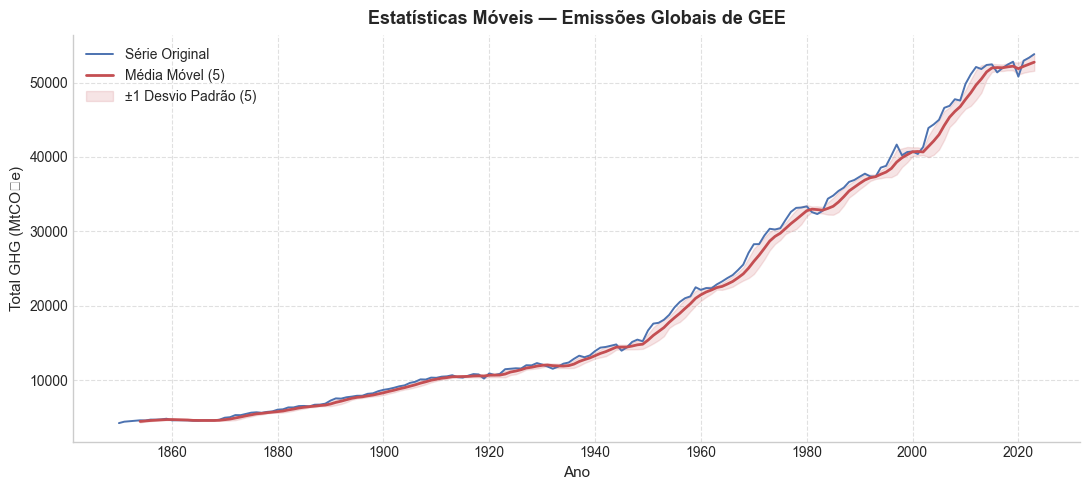


📊 Resultado do Teste Dickey-Fuller:

Estatística       2.4986
Valor-p           0.9990
Lags             12.0000
Nº Obs.         161.0000
Crítico (5%)     -2.8797
dtype: float64

📊 Resultado do Teste KPSS:

Estatística     1.6823
Valor-p         0.0100
Lags            9.0000
Crítico (5%)    0.4630
dtype: float64

📘 Interpretação:
- ADF: p=0.999 → não indica estacionariedade. (H₀: não estacionária)
- KPSS: p=0.01 → rejeita estacionariedade. (H₀: estacionária)
⚠️ Conclusão: a série provavelmente não é estacionária.



{'ADF p': 0.9990493982482325, 'KPSS p': 0.01, 'is_stationary': False}

In [19]:
def testa_estacionariedade(
    serie,
    window=5,
    titulo="Estatísticas Móveis e Testes de Estacionariedade",
    alpha=0.05,
    executar_kpss=True,
    ylabel="Total GHG (MtCO₂e)"
):
    plt.style.use("seaborn-v0_8-whitegrid")

    y = pd.Series(serie).astype(float).replace([np.inf, -np.inf], np.nan).dropna()

    # --- Estatísticas móveis ---
    rolmean = y.rolling(window=window).mean()
    rolstd  = y.rolling(window=window).std()

    # bandas (±1 desvio padrão em torno da média móvel)
    lower = rolmean - rolstd
    upper = rolmean + rolstd

    plt.figure(figsize=(11, 5))
    plt.plot(y, color="#4C72B0", label="Série Original", linewidth=1.4)
    plt.plot(rolmean, color="#C44E52", label=f"Média Móvel ({window})", linewidth=2)

    # >>> Sombra do desvio-padrão <<<
    plt.fill_between(
        y.index, lower, upper,
        color="#C44E52", alpha=0.15, label=f"±1 Desvio Padrão ({window})"
    )

    plt.title(titulo, fontsize=13, weight="semibold", pad=8)
    plt.xlabel("Ano", fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    plt.legend(frameon=False)
    plt.grid(True, linestyle="--", alpha=0.6)
    for s in ["top", "right"]:
        plt.gca().spines[s].set_visible(False)
    plt.tight_layout()
    plt.show()

    # --- Testes ---
    adf_stat, adf_p, adf_lags, adf_nobs, adf_crit, _ = adfuller(y, autolag="AIC")
    print("\n📊 Resultado do Teste Dickey-Fuller:\n")
    print(pd.Series({
        "Estatística": adf_stat,
        "Valor-p": adf_p,
        "Lags": adf_lags,
        "Nº Obs.": adf_nobs,
        "Crítico (5%)": adf_crit["5%"]
    }).round(4))

    if executar_kpss:
        print("\n📊 Resultado do Teste KPSS:\n")
        kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(y, regression="c", nlags="auto")
        print(pd.Series({
            "Estatística": kpss_stat,
            "Valor-p": kpss_p,
            "Lags": kpss_lags,
            "Crítico (5%)": kpss_crit["5%"]
        }).round(4))

    print("\n📘 Interpretação:")
    txt_adf = "indica estacionariedade" if adf_p < alpha else "não indica estacionariedade"
    print(f"- ADF: p={adf_p:.3g} → {txt_adf}. (H₀: não estacionária)")
    if executar_kpss:
        txt_kpss = "não rejeita estacionariedade" if kpss_p > alpha else "rejeita estacionariedade"
        print(f"- KPSS: p={kpss_p:.3g} → {txt_kpss}. (H₀: estacionária)")

    is_stat = (adf_p < alpha) and (not executar_kpss or kpss_p > alpha)
    print("✅ Conclusão: a série pode ser considerada estacionária.\n" if is_stat
          else "⚠️ Conclusão: a série provavelmente não é estacionária.\n")

    return {"ADF p": adf_p, "KPSS p": (kpss_p if executar_kpss else None), "is_stationary": is_stat}

testa_estacionariedade(
    serie["total_ghg"],
    window=5,
    titulo="Estatísticas Móveis — Emissões Globais de GEE",
    alpha=0.05
)

## **Transformando em uma série estacionária**

— Δ1 —


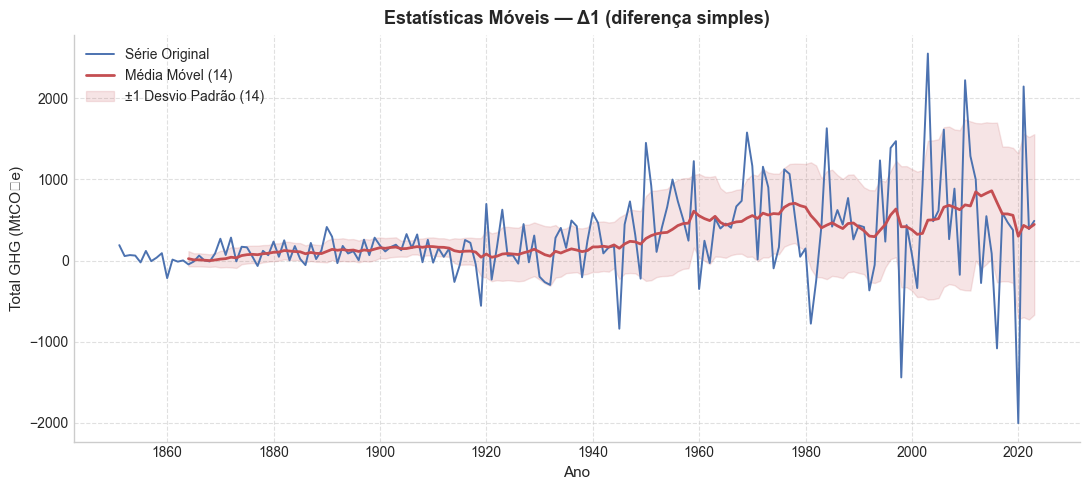


📊 Resultado do Teste Dickey-Fuller:

Estatística      -2.4983
Valor-p           0.1159
Lags             10.0000
Nº Obs.         162.0000
Crítico (5%)     -2.8796
dtype: float64

📊 Resultado do Teste KPSS:

Estatística     1.354
Valor-p         0.010
Lags            5.000
Crítico (5%)    0.463
dtype: float64

📘 Interpretação:
- ADF: p=0.116 → não indica estacionariedade. (H₀: não estacionária)
- KPSS: p=0.01 → rejeita estacionariedade. (H₀: estacionária)
⚠️ Conclusão: a série provavelmente não é estacionária.

— log1p —


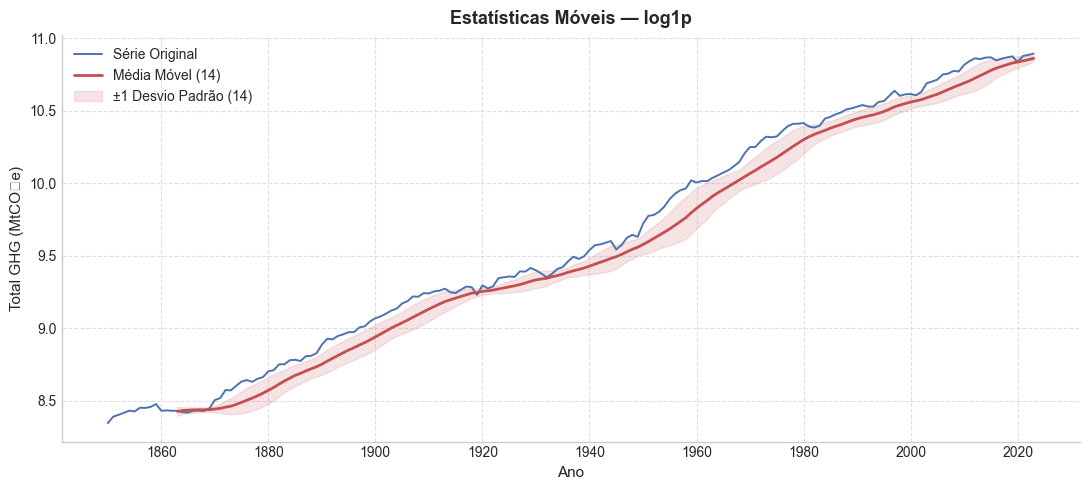


📊 Resultado do Teste Dickey-Fuller:

Estatística      -0.0477
Valor-p           0.9544
Lags              0.0000
Nº Obs.         173.0000
Crítico (5%)     -2.8784
dtype: float64

📊 Resultado do Teste KPSS:

Estatística     1.8282
Valor-p         0.0100
Lags            9.0000
Crítico (5%)    0.4630
dtype: float64

📘 Interpretação:
- ADF: p=0.954 → não indica estacionariedade. (H₀: não estacionária)
- KPSS: p=0.01 → rejeita estacionariedade. (H₀: estacionária)
⚠️ Conclusão: a série provavelmente não é estacionária.

— log1p + Δ1 —


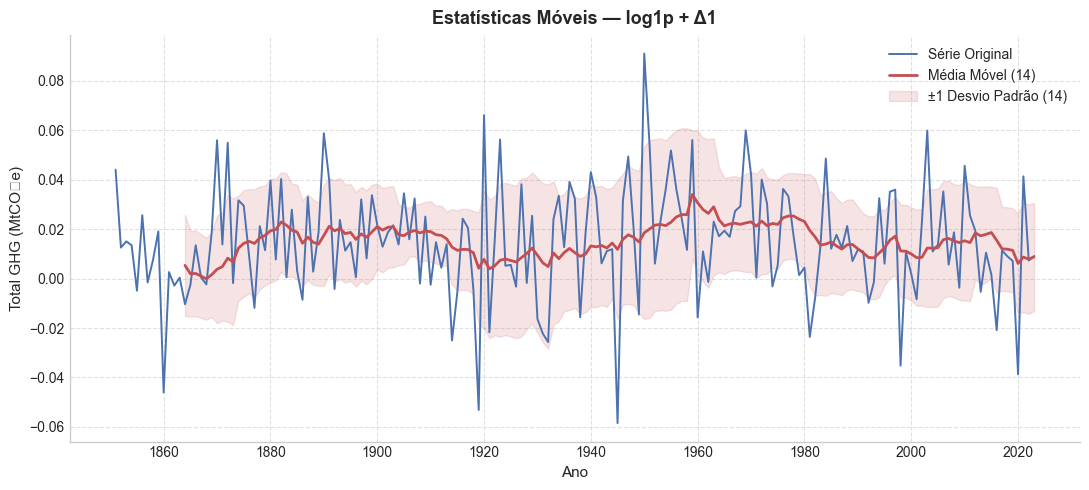


📊 Resultado do Teste Dickey-Fuller:

Estatística      -5.5861
Valor-p           0.0000
Lags              4.0000
Nº Obs.         168.0000
Crítico (5%)     -2.8789
dtype: float64

📊 Resultado do Teste KPSS:

Estatística     0.1018
Valor-p         0.1000
Lags            4.0000
Crítico (5%)    0.4630
dtype: float64

📘 Interpretação:
- ADF: p=1.36e-06 → indica estacionariedade. (H₀: não estacionária)
- KPSS: p=0.1 → não rejeita estacionariedade. (H₀: estacionária)
✅ Conclusão: a série pode ser considerada estacionária.



{'ADF p': 1.3617254427501264e-06, 'KPSS p': 0.1, 'is_stationary': True}

In [20]:
# 1) Série
y = serie["total_ghg"]

# 2) Três alternativas de estacionarização
y_d1        = y.diff(1).dropna()                    # Δ1
y_log = np.log(y).dropna()                            # log
y_log_d1     = np.log(y).diff(1).dropna()           # log + Δ1

# 3) Teste rápido
print("— Δ1 —")
testa_estacionariedade(y_d1, window=14,
    titulo="Estatísticas Móveis — Δ1 (diferença simples)")
print("— log1p —")
testa_estacionariedade(y_log, window=14,
    titulo="Estatísticas Móveis — log1p")
print("— log1p + Δ1 —")
testa_estacionariedade(y_log_d1, window=14,
    titulo="Estatísticas Móveis — log1p + Δ1")

Nos gráficos, na diferença simples (Δ1), a média móvel oscila em torno de zero, mas a variação vai ficando maior ao longo do tempo, mostrando que ainda não há constância. Ou seja, a tendência diminuiu, mas a série ainda não é totalmente estável.
Na transformação logarítmica (log), a média móvel segue subindo de forma quase linear, mostrando o crescimento contínuo das emissões ao longo dos anos.
Por fim, na combinação log + Δ1, a linha da média móvel fica mais estável e as oscilações diminuem, indicando que a série passou a variar em torno de uma média quase constante, ou seja, se tornou estacionária.

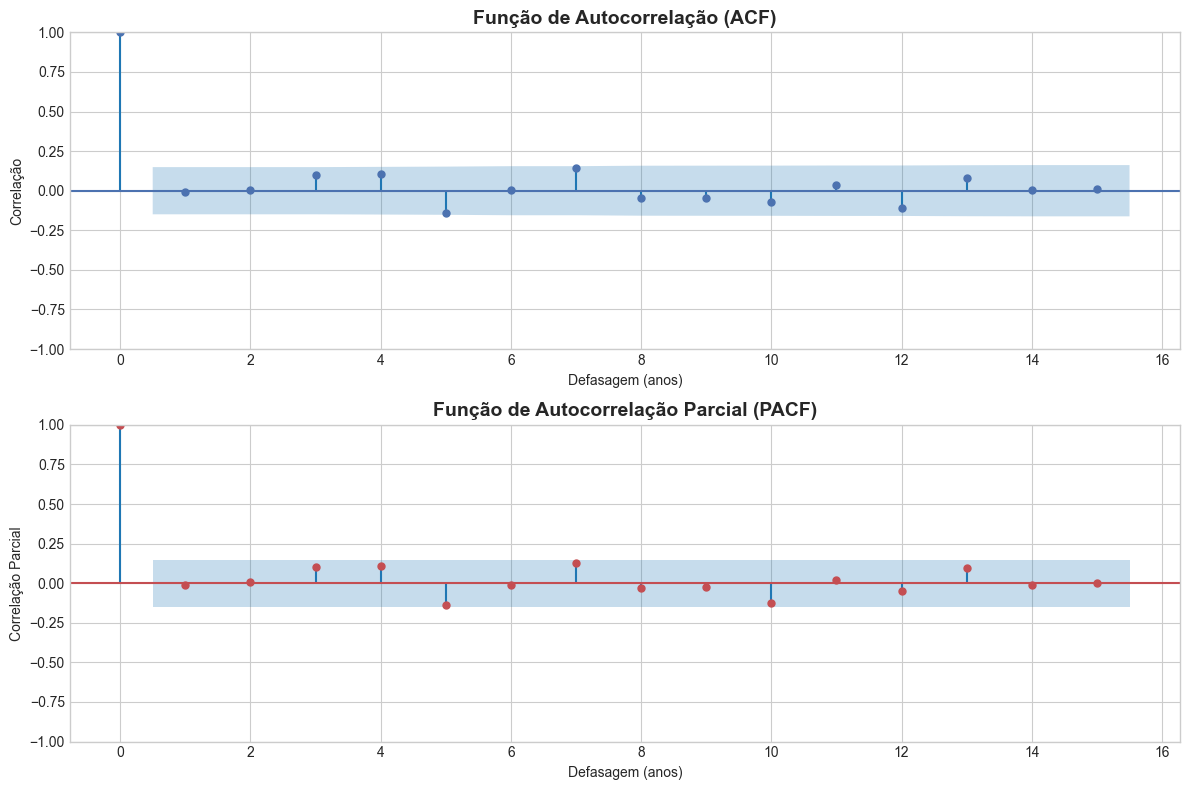

In [21]:
# Quantidade de defasagens (lags)
lags = 15 # 15 anos de dados anuais

# Plot ACF e PACF
plt.rcParams.update({'figure.figsize': (12,8)})

plt.subplot(211)
plot_acf(y_log_d1, ax=plt.gca(), lags=lags, color="#4C72B0")
plt.title("Função de Autocorrelação (ACF)", fontsize=14, weight="semibold")
plt.xlabel("Defasagem (anos)")
plt.ylabel("Correlação")

plt.subplot(212)
plot_pacf(y_log_d1, ax=plt.gca(), lags=lags, method="ywm", color="#C44E52")
plt.title("Função de Autocorrelação Parcial (PACF)", fontsize=14, weight="semibold")
plt.xlabel("Defasagem (anos)")
plt.ylabel("Correlação Parcial")

plt.tight_layout()
plt.show()

Após a transformação log + Δ1, foi possível verificar que a série se tornou estacionária, conforme indicado pelos testes ADF e KPSS.
Para complementar a análise, foram observadas as funções de autocorrelação (ACF) e autocorrelação parcial (PACF).

A PACF reflete o comportamento do componente autorregressivo (p), enquanto a ACF está relacionada ao componente de média móvel (q).
Nos gráficos, nota-se que ambas as funções decaem rapidamente para zero, sem apresentar picos relevantes fora do intervalo de confiança. Esse comportamento confirma a ausência de dependências temporais persistentes, reforçando que a série já não apresenta tendência ou sazonalidade.

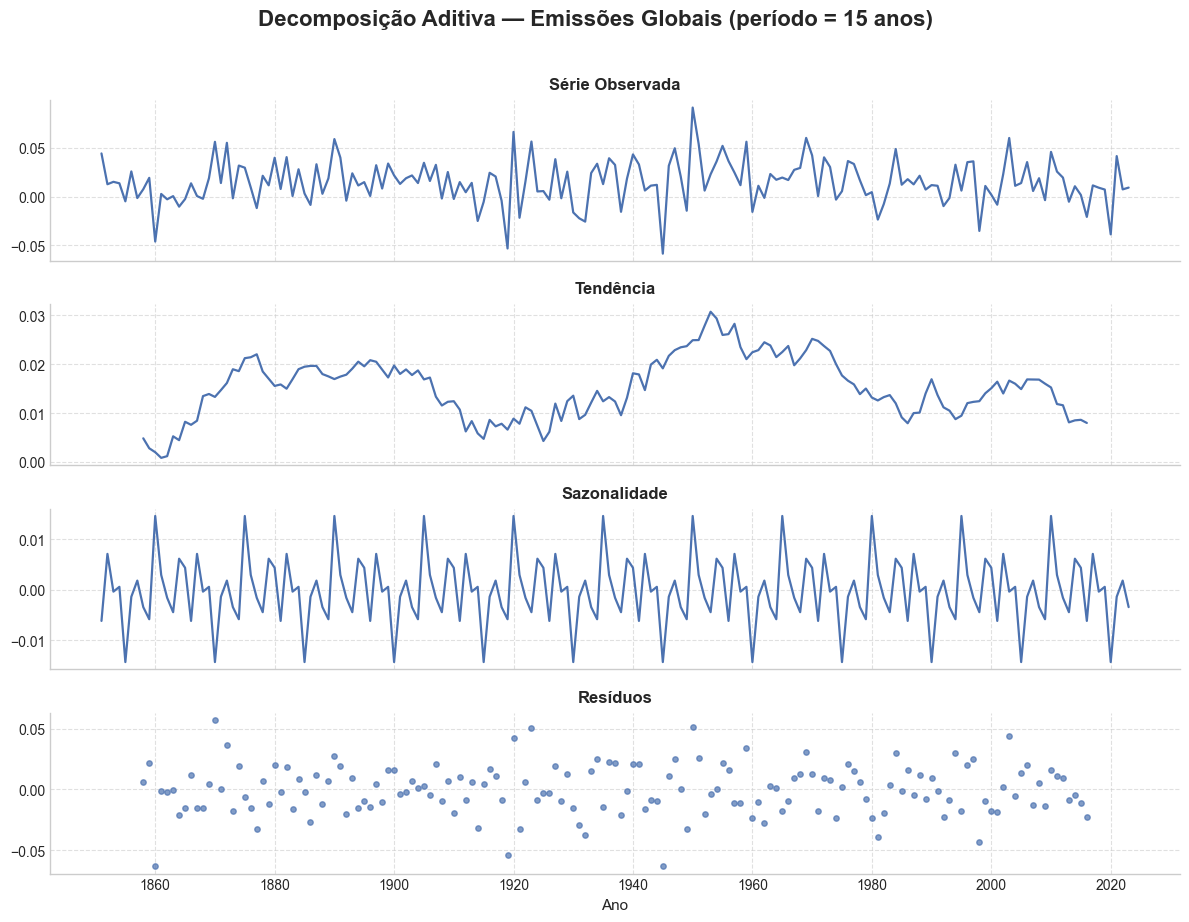

In [22]:
decomposicao_aditiva = plot_decomposition(
    y_log_d1,
    model="additive",
    period=15,
    color="#4C72B0",
    title="Decomposição Aditiva — Emissões Globais (período = 15 anos)"
)

Com a transformação logarítmica e a diferenciação, a série passou a apresentar valores positivos e negativos em torno de zero, o que faz com que a decomposição aditiva seja mais adequada. Na decomposição multiplicativa, precisaríamos de valores somente positivos, o que já não é o caso aqui.
Assim, foi realizada apenas a decomposição aditiva para representar o comportamento da série.
É possível observar que não há mais uma tendência clara de crescimento, surgindo oscilações e ciclos em torno de zero. Além disso, os resíduos permanecem distribuídos de forma aproximadamente constante, próximos de zero, o que indica que a estrutura foi bem capturada pela transformação.

## **Treinamento do Modelo**

In [23]:
serie = serie[coluna].astype(float)

### **Dividindo os dados em treino e teste (escala original)**

In [24]:
split = int(len(serie) * 0.80)
treino_original = serie.iloc[:split]
teste_original  = serie.iloc[split:]

In [25]:
print(f"Tamanho treino: {len(treino_original)} anos")
print(f"Tamanho teste:  {len(teste_original)} anos")

Tamanho treino: 139 anos
Tamanho teste:  35 anos


### **Dividindo os dados em treino e teste (escala log)**

In [26]:
# Divisão treino/teste usando a série log-transformada
split = int(len(y_log) * 0.80)
treino_log = y_log.iloc[:split]
teste_log = y_log.iloc[split:]

In [27]:
print(f"Tamanho treino: {len(treino_log)} anos")
print(f"Tamanho teste:  {len(teste_log)} anos")

Tamanho treino: 139 anos
Tamanho teste:  35 anos


### **SES, Holt e Holt-Winters**

In [28]:
# ========= SES =========
# Simple Exponential Smoothing - Sem tendência e sazonalidade
ses = SimpleExpSmoothing(treino_original).fit()
fc_ses = pd.Series(ses.forecast(len(teste_original)), index=teste_original.index, name="SES")

# ========= Holt =========
# Holt's Linear Trend Model - Com tendência, sem sazonalidade
holt = ExponentialSmoothing(treino_original, trend="add").fit()
fc_holt = pd.Series(holt.forecast(len(teste_original)), index=teste_original.index, name="Holt")

# ========= Holt-Winters (Aditivo com sazonalidade) =========
# Modelo com tendência e sazonalidade aditivas
holt_winters = ExponentialSmoothing(
    treino_original,
    trend="add",        # tendência aditiva
    seasonal="add",     # sazonalidade aditiva
    seasonal_periods=5  # período sazonal (exemplo: 5 anos)
).fit()

# Previsão
fc_holt_winters = pd.Series(
    holt_winters.forecast(len(teste_original)),
    index=teste_original.index,
    name="Holt-Winters"
)

In [30]:
# === Avaliação dos modelos no conjunto de TESTE ===
mse_ses  = mean_squared_error(teste_original, fc_ses)
mse_holt = mean_squared_error(teste_original, fc_holt)
mse_hw  = mean_squared_error(teste_original, fc_holt_winters)

rmse_ses  = np.sqrt(mse_ses)
rmse_holt = np.sqrt(mse_holt)
rmse_hw  = np.sqrt(mse_hw)

mae_ses  = mean_absolute_error(teste_original, fc_ses)
mae_holt = mean_absolute_error(teste_original, fc_holt)
mae_hw  = mean_absolute_error(teste_original, fc_holt_winters)

print("=== Erros no conjunto de TESTE ===")
print(f"SES : RMSE={rmse_ses:,.1f} | MAE={mae_ses:,.1f}")
print(f"Holt: RMSE={rmse_holt:,.1f} | MAE={mae_holt:,.1f}")
print(f"Holt-Winters : RMSE={rmse_hw:,.1f} | MAE={mae_hw:,.1f}")

=== Erros no conjunto de TESTE ===
SES : RMSE=10,833.2 | MAE=9,081.5
Holt: RMSE=1,530.1 | MAE=1,225.7
Holt-Winters : RMSE=1,527.4 | MAE=1,224.4


In [34]:
# === AIC e BIC dos Modelos ===
print("=== Critérios de Informação ===")
print(f"{'Modelo':<15}{'AIC':>12}{'BIC':>12}")
print("-" * 39)
print(f"{'SES':<15}{ses.aic:>12.2f}{ses.bic:>12.2f}")
print(f"{'Holt':<15}{holt.aic:>12.2f}{holt.bic:>12.2f}")
print(f"{'Holt-Winters':<15}{holt_winters.aic:>12.2f}{holt_winters.bic:>12.2f}")

=== Critérios de Informação ===
Modelo                  AIC         BIC
---------------------------------------
SES                 1706.69     1712.56
Holt                1646.81     1658.55
Holt-Winters        1657.42     1683.83


📊 *O AIC (Akaike Information Criterion) e o BIC (Bayesian Information Criterion) medem a qualidade do ajuste penalizando modelos muito complexos; quanto menores seus valores, melhor o equilíbrio entre precisão e simplicidade.*

#### 🧩 **Interpretação dos Modelos**

- **SES (Simple Exponential Smoothing)**  
  Por não considerar tendência nem sazonalidade, o modelo não acompanha o crescimento da série, resultando em **erros altos (RMSE e MAE)**.  
  O **AIC e BIC mais elevados** indicam um **ajuste estatisticamente inferior**.

- **Holt (Linear Trend Model)**  
  Inclui uma **tendência linear**, o que melhora o ajuste.  
  Apresenta **menores erros** e **AIC/BIC mais baixos**, mostrando **melhor equilíbrio entre precisão e simplicidade**.

- **Holt-Winters (Aditivo com Sazonalidade)**  
  Apesar de incluir uma **componente sazonal**, o desempenho é **muito próximo ao de Holt**, sem redução relevante nos erros.  
  Isso confirma que **não há sazonalidade real** na série e que o **modelo Holt** é o mais adequado.

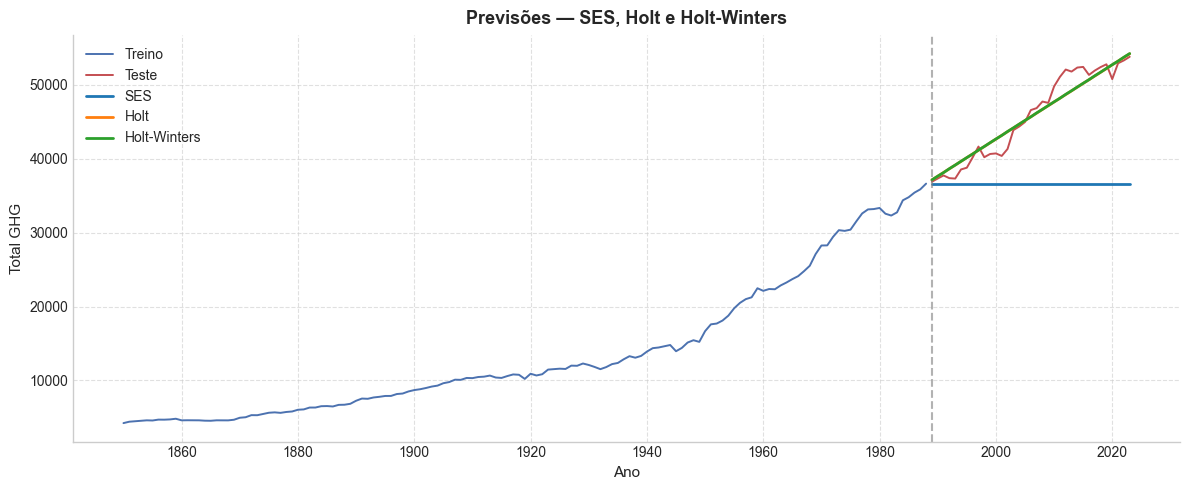

In [35]:
plt.figure(figsize=(12,5))
plt.style.use("seaborn-v0_8-whitegrid")

plt.plot(treino_original, label="Treino", color="#4C72B0", linewidth=1.4)
plt.plot(teste_original,  label="Teste",  color="#C44E52", linewidth=1.4)
plt.plot(fc_ses,  label="SES",  linewidth=2)
plt.plot(fc_holt, label="Holt", linewidth=2)
plt.plot(fc_holt_winters,  label="Holt-Winters",  linewidth=2)

# Linha vertical indicando o ponto de corte (início do teste)
plt.axvline(teste_original.index[0], linestyle="--", color="gray", alpha=0.6)

# Estilo e rótulos
plt.title("Previsões — SES, Holt e Holt-Winters", fontsize=13, weight="semibold", pad=8)
plt.xlabel("Ano", fontsize=11)
plt.ylabel("Total GHG", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(frameon=False)
for s in ["top", "right"]:
    plt.gca().spines[s].set_visible(False)

plt.tight_layout()
plt.show()

### **ARIMA VS SARIMA**

Foram ajustados os modelos **ARIMA(1,1,1)** e **SARIMA(1,1,1)(1,1,4)[15]** para a série transformada (log + diferença).  
O **ARIMA** usa apenas os componentes de **tendência e dependência temporal**, sem considerar sazonalidade.  
Já o **SARIMA** adiciona termos sazonais, tentando capturar possíveis **ciclos de longo prazo** (com período de 15 anos).

In [42]:
# ===== ARIMA (sem sazonalidade) =====
arima = SARIMAX(
    treino_log,
    order=(1,1,1),                 # ARIMA(p,d,q)
    seasonal_order=(0,0,0,0)      # sem sazonalidade
)

# ARIMA(1,1,0), ARIMA(0,1,1) e ARIMA(1,1,1)

arima = arima.fit(disp=True)

# Forecast
fc_arima = pd.Series(arima.forecast(steps=len(teste_log)), index=teste_log.index, name="ARIMA")

# ===== SARIMA =====
sarima = SARIMAX(
    treino_log,
    order=(1,1,1),             # SARIMA(p,d,q)
    seasonal_order=(1,1,4,15)   # (P,D,Q,s)
)

sarima = sarima.fit(disp=True)

fc_sarima = pd.Series(sarima.forecast(steps=len(teste_log)), index=teste_log.index,
                      name=f"SARIMA")

In [43]:
# RMSE e MAE
rmse_arima = np.sqrt(mean_squared_error(teste_log, fc_arima))
mae_arima  = mean_absolute_error(teste_log, fc_arima)

rmse_sarima = np.sqrt(mean_squared_error(teste_log, fc_sarima))
mae_sarima  = mean_absolute_error(teste_log, fc_sarima)

print("=== Erros no conjunto de TESTE ===")
print(f"ARIMA : RMSE={rmse_arima:,.4f} | MAE={mae_arima:,.4f}")
print(f"SARIMA: RMSE={rmse_sarima:,.4f} | MAE={mae_sarima:,.4f}")

=== Erros no conjunto de TESTE ===
ARIMA : RMSE=0.0982 | MAE=0.0847
SARIMA: RMSE=0.0755 | MAE=0.0611


In [44]:
# === Critérios de Informação (ARIMA e SARIMA) ===
print("=== Critérios de Informação ===")
print(f"{'Modelo':<15}{'AIC':>12}{'BIC':>12}")
print("-" * 39)
print(f"{'ARIMA':<15}{arima.aic:>12.2f}{arima.bic:>12.2f}")
print(f"{'SARIMA':<15}{sarima.aic:>12.2f}{sarima.bic:>12.2f}")

=== Critérios de Informação ===
Modelo                  AIC         BIC
---------------------------------------
ARIMA               -640.49     -631.70
SARIMA              -531.86     -509.37


#### 🧩 **Interpretação dos Modelos**

Os resultados mostram que o **SARIMA teve erros um pouco menores** (RMSE = 0.0755; MAE = 0.0611) que o ARIMA (RMSE = 0.0982; MAE = 0.0847).  
Por outro lado, o **ARIMA apresentou valores menores de AIC e BIC**, o que indica um **modelo mais simples e eficiente**.  
Assim, ambos representam bem o comportamento da série, mas o **ARIMA explica a variação dos dados de forma mais direta**, enquanto o **SARIMA adiciona complexidade sem ganho expressivo**.

In [45]:
# Invertendo a transformação log para as previsões
fc_arima_exp = np.exp(fc_arima)
fc_sarima_exp = np.exp(fc_sarima)

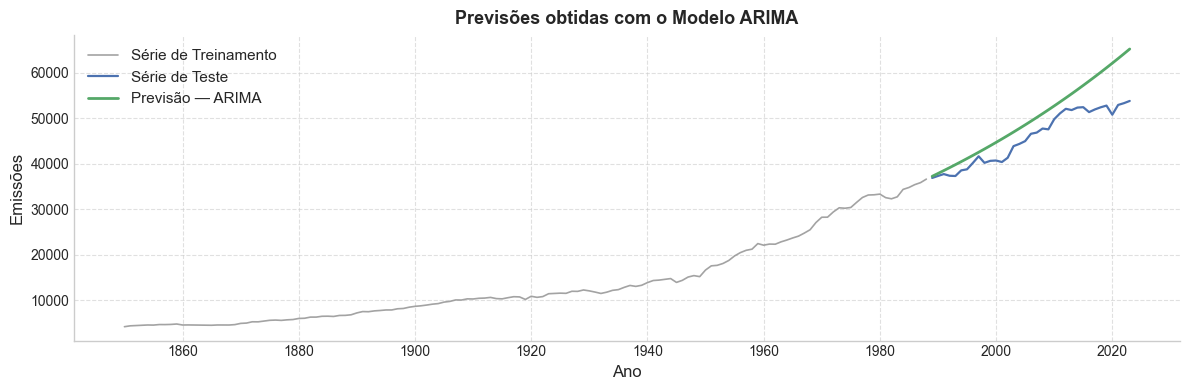

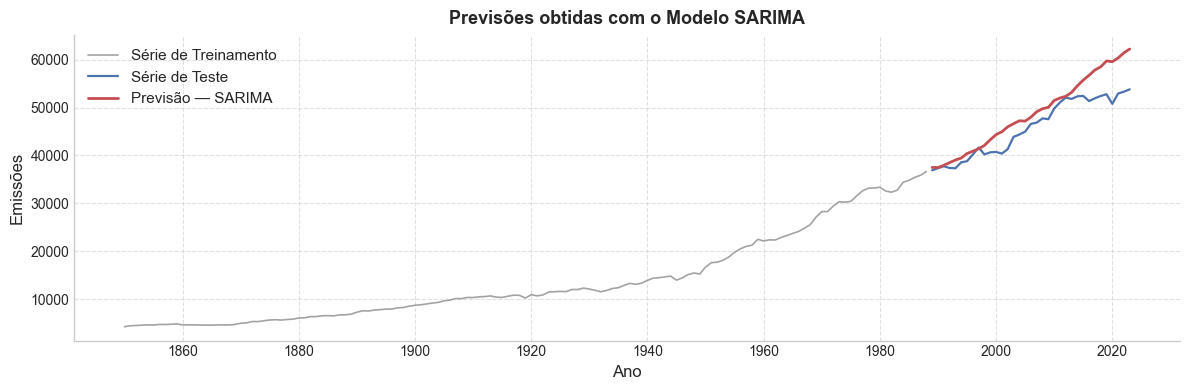

In [46]:
def plot_previsao_modelo(treino, teste, previsao, nome_modelo, color="#55A868", log=True):
    """
    Gera gráfico padronizado para um modelo de previsão temporal.
    """
    plt.figure(figsize=(12,4))
    plt.style.use("seaborn-v0_8-whitegrid")

    # Séries
    plt.plot(treino, label="Série de Treinamento", color="#999999", linewidth=1.2, alpha=0.9)
    plt.plot(teste, label="Série de Teste", color="#4C72B0", linewidth=1.6)
    plt.plot(previsao, label=f"Previsão — {nome_modelo}", color=color, linewidth=2.0)

    # Estilo
    plt.title(f"Previsões obtidas com o Modelo {nome_modelo}", fontsize=13, weight="semibold", pad=8)
    plt.xlabel("Ano", fontsize=12)
    ylabel = "Emissões"
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(frameon=False, loc="upper left", fontsize=11)
    plt.grid(True, linestyle="--", alpha=0.6)
    
    # Limpeza estética
    for s in ["top", "right"]:
        plt.gca().spines[s].set_visible(False)

    plt.tight_layout()
    plt.show()
    
# === ARIMA ===
plot_previsao_modelo(treino_original, teste_original, fc_arima_exp, "ARIMA", color="#55A868", log=False)

# === SARIMA ===
plot_previsao_modelo(treino_original, teste_original, fc_sarima_exp, "SARIMA", color="#C44E52", log=False)

Nos gráficos, é possível observar que o **ARIMA** acompanha bem a tendência geral da série, mas tende a suavizar as variações mais recentes, subestimando levemente os valores no final do período de teste.  
Já o **SARIMA** mantém o mesmo padrão crescente, porém suas previsões se mostram **mais ajustadas aos últimos valores observados**, o que explica os erros ligeiramente menores.  

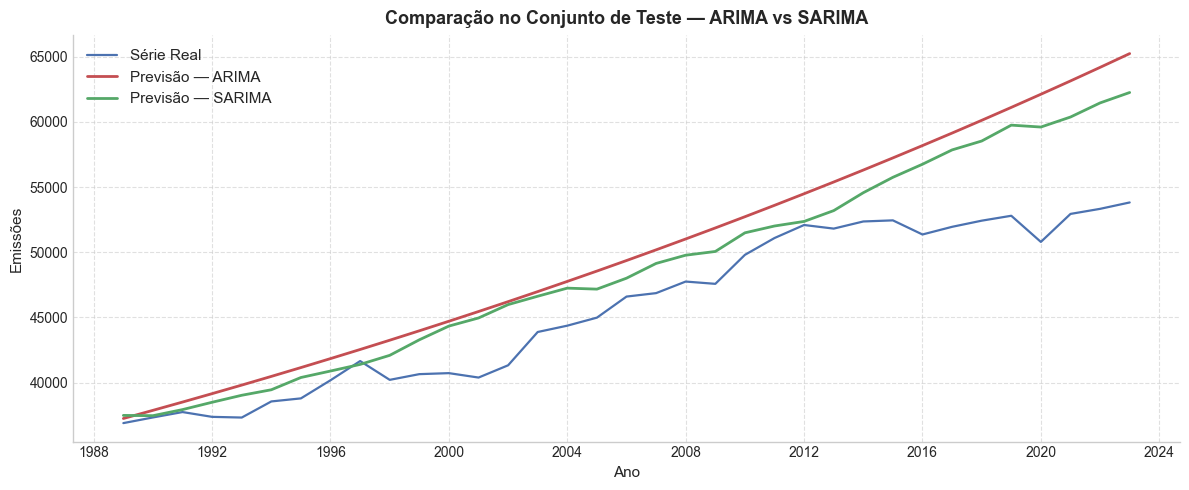

In [132]:
def plot_previsoes_comparacao(teste, fc1, fc2, nome1, nome2, titulo, ylabel, log=False):
    plt.figure(figsize=(12,5))
    plt.style.use("seaborn-v0_8-whitegrid")

    plt.plot(teste, label="Série Real" + (" (log)" if log else ""), color="#4C72B0", linewidth=1.6)
    plt.plot(fc1, label=nome1, color="#C44E52", linewidth=2)
    plt.plot(fc2, label=nome2, color="#55A868", linewidth=2)

    plt.title(titulo, fontsize=13, weight="semibold", pad=8)
    plt.xlabel("Ano", fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    plt.legend(frameon=False, loc="upper left", fontsize=11)
    plt.grid(True, linestyle="--", alpha=0.6)
    
    for s in ["top", "right"]:
        plt.gca().spines[s].set_visible(False)

    plt.tight_layout()
    plt.show()

plot_previsoes_comparacao(
    teste_original, 
    fc_arima_exp, fc_sarima_exp,
    "Previsão — ARIMA", "Previsão — SARIMA",
    "Comparação no Conjunto de Teste — ARIMA vs SARIMA",
    "Emissões",
    log=False
)

In [47]:
def diagnosticos_residuos(model, lags=15, titulo="Diagnóstico de Resíduos"):
    # --- resíduos padronizados
    resid = pd.Series(model.resid).dropna()
    std_resid = (resid - resid.mean()) / resid.std(ddof=1)

    # === figura 2x2 ===
    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    ax_ts, ax_hist, ax_qq, ax_acf = axes.ravel()

    # (1) Série temporal
    ax_ts.plot(std_resid, color="#4C72B0", linewidth=1.2)
    ax_ts.set_title("Standardized residual", fontsize=12, weight="semibold")
    ax_ts.set_xlabel(""); ax_ts.set_ylabel("")
    ax_ts.grid(True, linestyle="--", alpha=0.6)

    # (2) Histograma + KDE + N(0,1)
    vals = std_resid.values
    ax_hist.hist(vals, bins=30, density=True, alpha=0.9,
                 edgecolor="white", color="#4C72B0", label="Hist")
    pd.Series(vals).plot(kind="kde", ax=ax_hist, linewidth=2.0,
                         color="#DD8452", label="KDE")
    xs = np.linspace(vals.min()-1, vals.max()+1, 300)
    ax_hist.plot(xs, norm.pdf(xs, 0, 1), linewidth=1.6,
                 color="#55A868", label="N(0,1)")
    ax_hist.set_title("Histogram plus estimated density", fontsize=12, weight="semibold")
    ax_hist.set_xlabel(""); ax_hist.set_ylabel("")
    ax_hist.legend(frameon=False)
    ax_hist.grid(True, linestyle="--", alpha=0.6)

    # (3) QQ-plot
    sm.qqplot(std_resid, line="45", ax=ax_qq,
              markerfacecolor="#4C72B0", markeredgecolor="none", alpha=0.9)
    ax_qq.set_title("Normal Q-Q", fontsize=12, weight="semibold")
    ax_qq.grid(True, linestyle="--", alpha=0.6)

    # (4) Correlograma
    plot_acf(std_resid, lags=lags, ax=ax_acf, alpha=0.05)
    ax_acf.set_title("Correlogram", fontsize=12, weight="semibold")
    ax_acf.set_xlabel(""); ax_acf.set_ylabel("")
    ax_acf.grid(True, linestyle="--", alpha=0.6)

    # estética
    for ax in [ax_ts, ax_hist, ax_qq, ax_acf]:
        for s in ["top", "right"]:
            ax.spines[s].set_visible(False)

    fig.suptitle(titulo, fontsize=13, weight="semibold", y=1.02)
    plt.tight_layout()
    plt.show()

    # Ljung–Box (resumo)
    lb = acorr_ljungbox(std_resid, lags=[10, 20], return_df=True)
    print("\n=== Ljung–Box ===")
    print(lb)
    if (lb["lb_pvalue"] > 0.05).all():
        print("\n✅ Resíduos sem autocorrelação — parecem ruído branco.")
    else:
        print("\n⚠ Autocorrelação detectada — modelo possivelmente subajustado.")

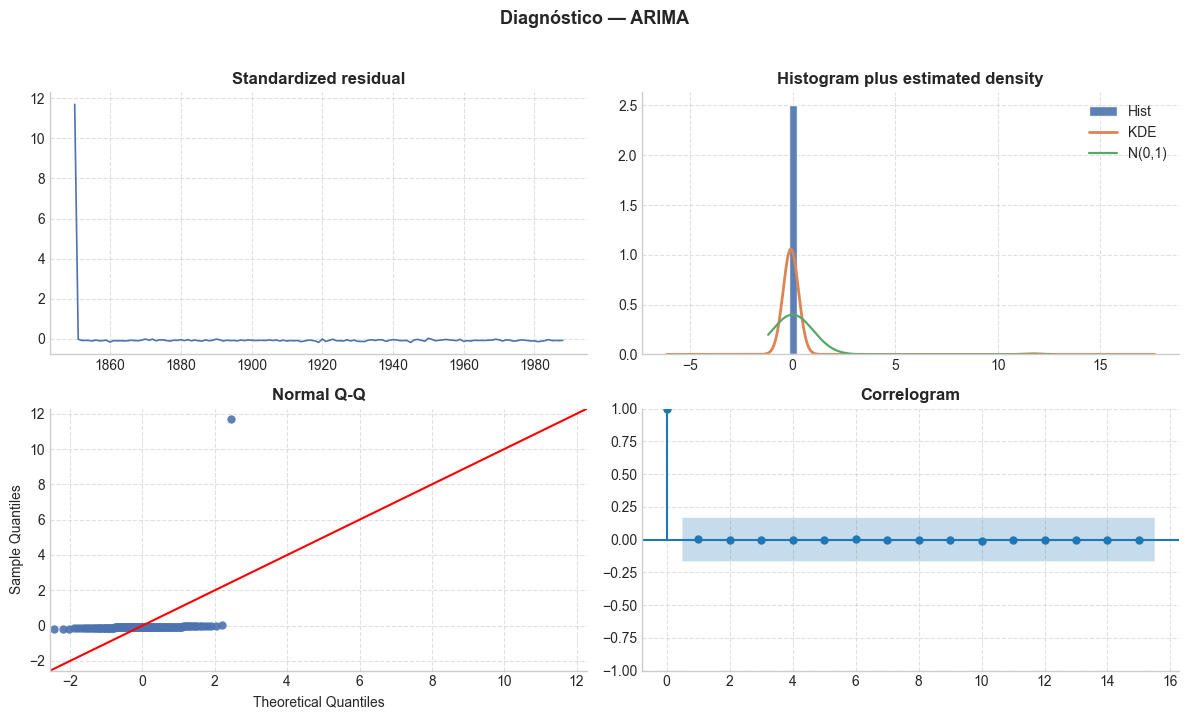


=== Ljung–Box ===
     lb_stat  lb_pvalue
10  0.015257        1.0
20  0.023944        1.0

✅ Resíduos sem autocorrelação — parecem ruído branco.


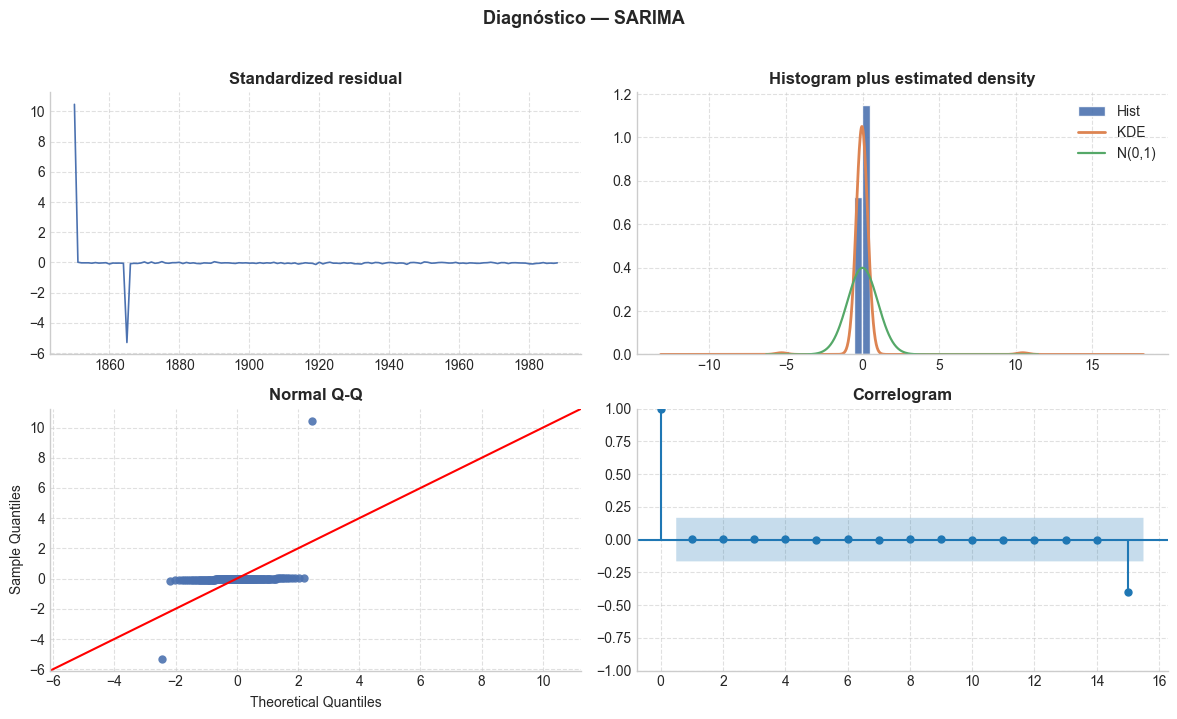


=== Ljung–Box ===
      lb_stat  lb_pvalue
10   0.022580   1.000000
20  25.484013   0.183537

✅ Resíduos sem autocorrelação — parecem ruído branco.


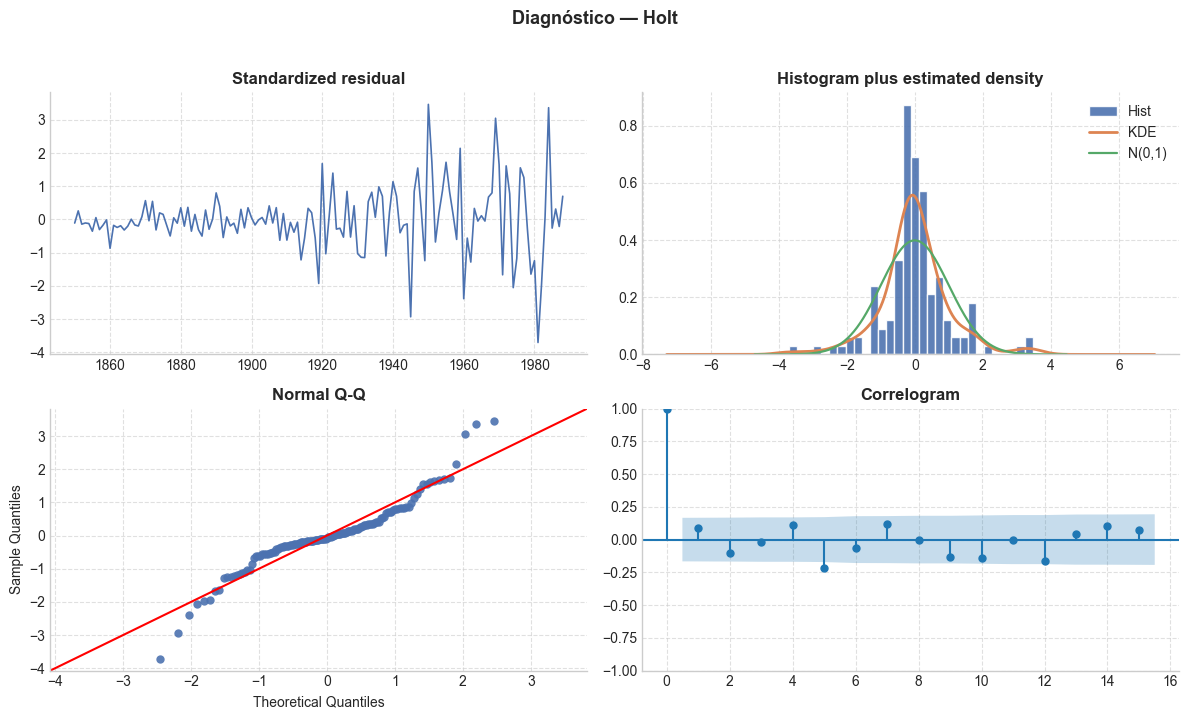


=== Ljung–Box ===
      lb_stat  lb_pvalue
10  19.912619   0.030090
20  34.344634   0.023886

⚠ Autocorrelação detectada — modelo possivelmente subajustado.


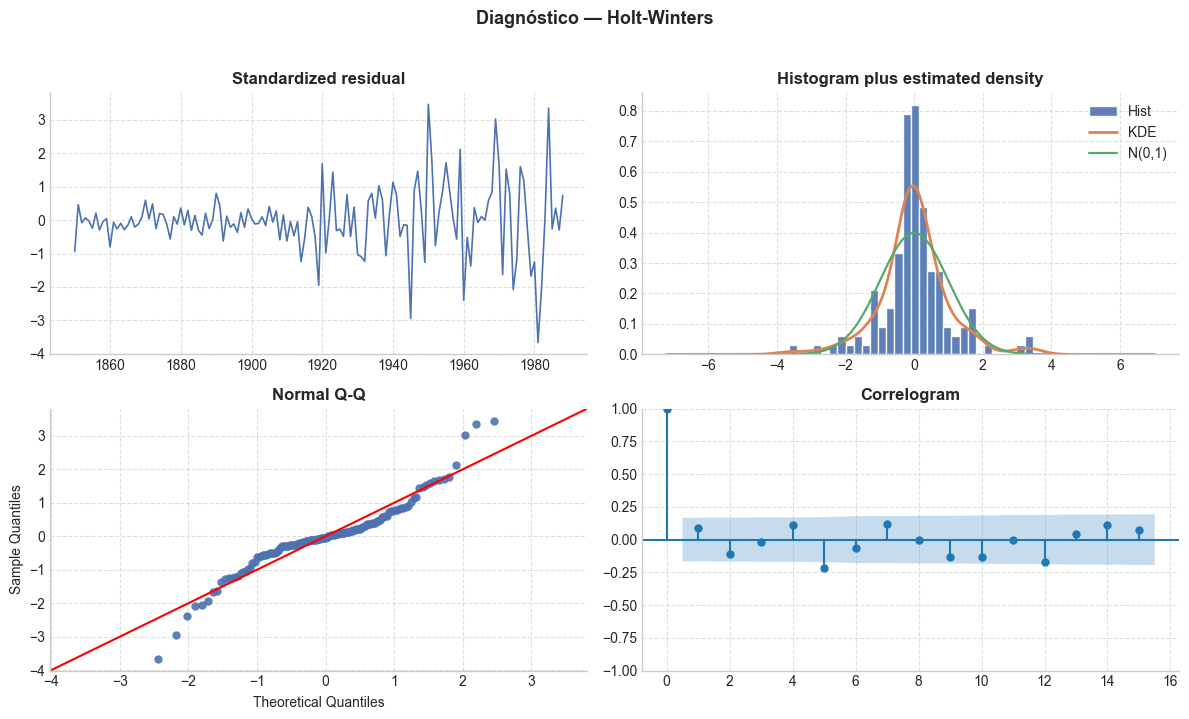


=== Ljung–Box ===
      lb_stat  lb_pvalue
10  19.940434   0.029821
20  34.481087   0.023049

⚠ Autocorrelação detectada — modelo possivelmente subajustado.


In [48]:
diagnosticos_residuos(arima,  lags=15, titulo="Diagnóstico — ARIMA")
diagnosticos_residuos(sarima, lags=15, titulo="Diagnóstico — SARIMA")
diagnosticos_residuos(holt,   lags=15, titulo="Diagnóstico — Holt")
diagnosticos_residuos(holt_winters,    lags=15, titulo="Diagnóstico — Holt-Winters")

#### **🔎 Diagnóstico dos resíduos**

**ARIMA(1,1,1)**  
Os resíduos ficam próximos de zero e sem padrão definido, o que é um bom sinal.  
A distribuição está centrada em zero, e os pontos do Q–Q plot seguem bem a linha.  
O correlograma não mostra autocorrelação (os resíduos parecem **ruído branco**).

**SARIMA(1,1,1)(1,1,4)[15]**  
Apresenta comportamento parecido com o ARIMA, também com resíduos próximos de zero.  
Há poucos outliers e uma leve variação nas extremidades.  
O correlograma confirma ausência de autocorrelação, indicando **ajuste adequado**.

**Holt (tendência aditiva)**  
Os resíduos ainda mostram pequenos agrupamentos, sugerindo dependência entre observações.  
A distribuição é mais espalhada e o Q–Q plot mostra desvios maiores da reta.  
Há autocorrelação nos testes (o modelo **não removeu toda a estrutura temporal**).

**Holt-Winters (aditivo)**  
Comportamento semelhante ao Holt: resíduos com certa regularidade e caudas mais largas.  
O correlograma mostra pequenas correlações em alguns lags, indicando **subajuste**.

In [52]:
# Inversa correta do log
INV = np.exp

treino_orig = INV(y_log.iloc[: int(len(y_log)*0.8)])
teste_orig  = INV(y_log.iloc[  int(len(y_log)*0.8):])

# Previsões para a escala original
fc_arima_orig  = INV(fc_arima)
fc_sarima_orig = INV(fc_sarima)
# SES/Holt/HW já estão na escala original -> não mexe

def calcular_metricas(y_true, y_pred, nome_modelo, modelo_fit=None):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    y_true, y_pred = y_true.align(y_pred, join="inner")
    m = (~y_true.isna()) & (~y_pred.isna())
    y_true, y_pred = y_true[m], y_pred[m]
    return {
        "Modelo": nome_modelo,
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
        "n": int(len(y_true)),
        "AIC": getattr(modelo_fit, "aic", np.nan),
        "BIC": getattr(modelo_fit, "bic", np.nan),
    }

metricas = [
    calcular_metricas(teste_orig, fc_ses,          "SES",    ses),
    calcular_metricas(teste_orig, fc_holt,         "Holt",   holt),
    calcular_metricas(teste_orig, fc_holt_winters, "Holt-Winters",    holt_winters),
    calcular_metricas(teste_orig, fc_arima_orig,   "ARIMA",  arima),
    calcular_metricas(teste_orig, fc_sarima_orig,  "SARIMA", sarima),
]

tabela = (pd.DataFrame(metricas)
          .sort_values("RMSE")
          .round({"MSE":6,"RMSE":2,"MAE":2,"R2":3,"AIC":1,"BIC":1})
          .reset_index(drop=True))
tabela

,Modelo,MSE,RMSE,MAE,R2,n,AIC,BIC
0,Holt-Winters,2.332871e+06,1527.37,1224.40,0.933,35,1657.4,1683.8
1,Holt,2.341211e+06,1530.10,1225.71,0.933,35,1646.8,1658.6
2,SARIMA,1.579771e+07,3974.63,3069.10,0.547,35,-531.9,-509.4
3,ARIMA,2.766441e+07,5259.70,4303.87,0.207,35,-640.5,-631.7
4,SES,1.173579e+08,10833.19,9081.51,-2.364,35,1706.7,1712.6


## **Conclusão Geral**

Os resultados mostram que **os modelos de suavização exponencial (Holt e Holt-Winters)** tiveram **melhor desempenho geral** nos indicadores de erro (RMSE e MAE) e nos critérios de informação (AIC e BIC), com **R² ≈ 0.93**, o que indica que explicam bem a variação da série.  
Mesmo assim, o diagnóstico dos resíduos revelou que **ambos ainda apresentam autocorrelação**, sugerindo que parte da estrutura temporal não foi completamente capturada.

Por outro lado, **ARIMA e SARIMA**, apesar de apresentarem **valores de erro mais altos e R² menores**, geraram **resíduos bem comportados**, sem autocorrelação e próximos de ruído branco, o que significa que conseguiram modelar adequadamente a dependência temporal da série.  
O **ARIMA**, em especial, apresentou o **menor AIC e BIC**, sendo o modelo mais simples entre todos.

> **Em resumo:**  
> - **Holt e Holt-Winters**: melhor ajuste numérico (menores erros), mas resíduos ainda correlacionados.  
> - **ARIMA e SARIMA**: resíduos bem distribuídos e aleatórios, representando modelos estatisticamente consistentes.  
> - Considerando o equilíbrio entre **simplicidade, ajuste e diagnóstico residual**, o **ARIMA(1,1,1)** se mostra o **modelo mais adequado** para representar o comportamento da série.